###  This code will read in the full datacube and run k-means clustering

It will then analyze the clusters

In [41]:
from astropy.io import fits
import matplotlib.pyplot as plt
import os
import re
import numpy as np
import matplotlib
class MidpointNormalize(matplotlib.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [2]:
# Need to pull all of the names that exist
#print(os.listdir())
# This will yield a tuple for each subdirectory. Ths first entry in the 3-tuple is a directory name, so:

plates = [x[2] for x in os.walk('/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_derotated_and_rescaled/')][0]
print('Searching through this directory for all of the existing ifus', plates)



existing_plateifus=[]

for j in range(len(plates)):
    ifu = re.split('.fits',plates[j])[0]
    existing_plateifus.append(str(ifu))
print(existing_plateifus)
print('this is how many galaxies you are working with', len(existing_plateifus))
# Now you need to construct plateifu names of what exists

Searching through this directory for all of the existing ifus ['7990-12701.fits', '7964-12703.fits', '7964-12702.fits', '9499-12704.fits', '7964-12705.fits', '9499-12703.fits', '7964-3703.fits', '7964-12704.fits', '8325-12705.fits', '8322-1901.fits', '8322-6102.fits', '7990-12705.fits', '9036-3701.fits', '9499-6103.fits', '9036-12703.fits', '8325-12703.fits', '7964-12701.fits', '7990-12702.fits', '9036-12705.fits']
['7990-12701', '7964-12703', '7964-12702', '9499-12704', '7964-12705', '9499-12703', '7964-3703', '7964-12704', '8325-12705', '8322-1901', '8322-6102', '7990-12705', '9036-3701', '9499-6103', '9036-12703', '8325-12703', '7964-12701', '7990-12702', '9036-12705']
this is how many galaxies you are working with 19


In [39]:
# Now you need to go through and pick out whatever data you want
# Let's say for example that you want to work with the stellar velocity and stellar velocity dispersion maps
file_ex = fits.open('kin_maps_derotated_and_rescaled/'+str(existing_plateifus[0])+'.fits')
length_cube = np.shape(file_ex[13].data)[0]**2
shape = int(np.sqrt(length_cube))

map_ml_stel_vel = np.zeros((len(plates), length_cube))
map_ml_stel_disp = np.zeros((len(plates), length_cube))
# The below cube contains everything, all of the velocity and velocity dispersion maps
map_ml_all_stel = np.zeros((len(plates), 2*length_cube))
for j in range(len(plates)):
    file = fits.open('kin_maps_derotated_and_rescaled/'+str(existing_plateifus[j])+'.fits')
    map_ml_stel_vel[j,:] = np.reshape(file[13].data,length_cube)
    map_ml_stel_disp[j,:] = np.reshape(file[14].data,length_cube)
    map_ml_all_stel[j,:400] = np.reshape(file[13].data,length_cube) 
    map_ml_all_stel[j,400:] = np.reshape(file[14].data,length_cube)
    
    continue
    plt.clf()
    plt.imshow(file[13].data, cmap='RdBu_r')
    plt.colorbar()
    plt.title(str(file[0].header['EXT12']))
    plt.show()
    
    plt.clf()
    plt.imshow(file[14].data, cmap='viridis')
    plt.colorbar()
    plt.title(str(file[0].header['EXT13']))
    plt.show()
    if j==0:
        break
data_ml_2d_vel = np.reshape(map_ml_stel_vel, (len(plates), shape, shape))  
data_ml_2d_disp = np.reshape(map_ml_stel_disp, (len(plates), shape, shape))  

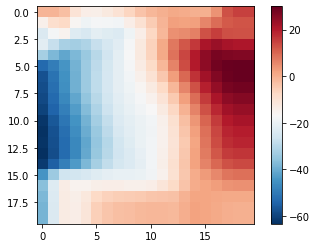

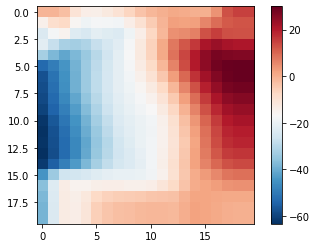

In [28]:
# Verify that this is done correctly

#print(map_ml_all_stel[0])
#print(map_ml_stel_vel[0])


test_n = 18

reconstruct_stel_vel = np.reshape(map_ml_all_stel[test_n,:400], (20,20))

plt.clf()
plt.imshow(reconstruct_stel_vel, cmap='RdBu_r')
plt.colorbar()
plt.show()

plt.clf()
plt.imshow(np.reshape(map_ml_stel_vel[test_n,:], (20,20)), cmap='RdBu_r')
plt.colorbar()
plt.show()

### The problem:
The problem is that this data is not coherent, we need a way to treat the two maps as overlapping pictures and not treat all of the pixels separately.

<Figure size 432x288 with 0 Axes>

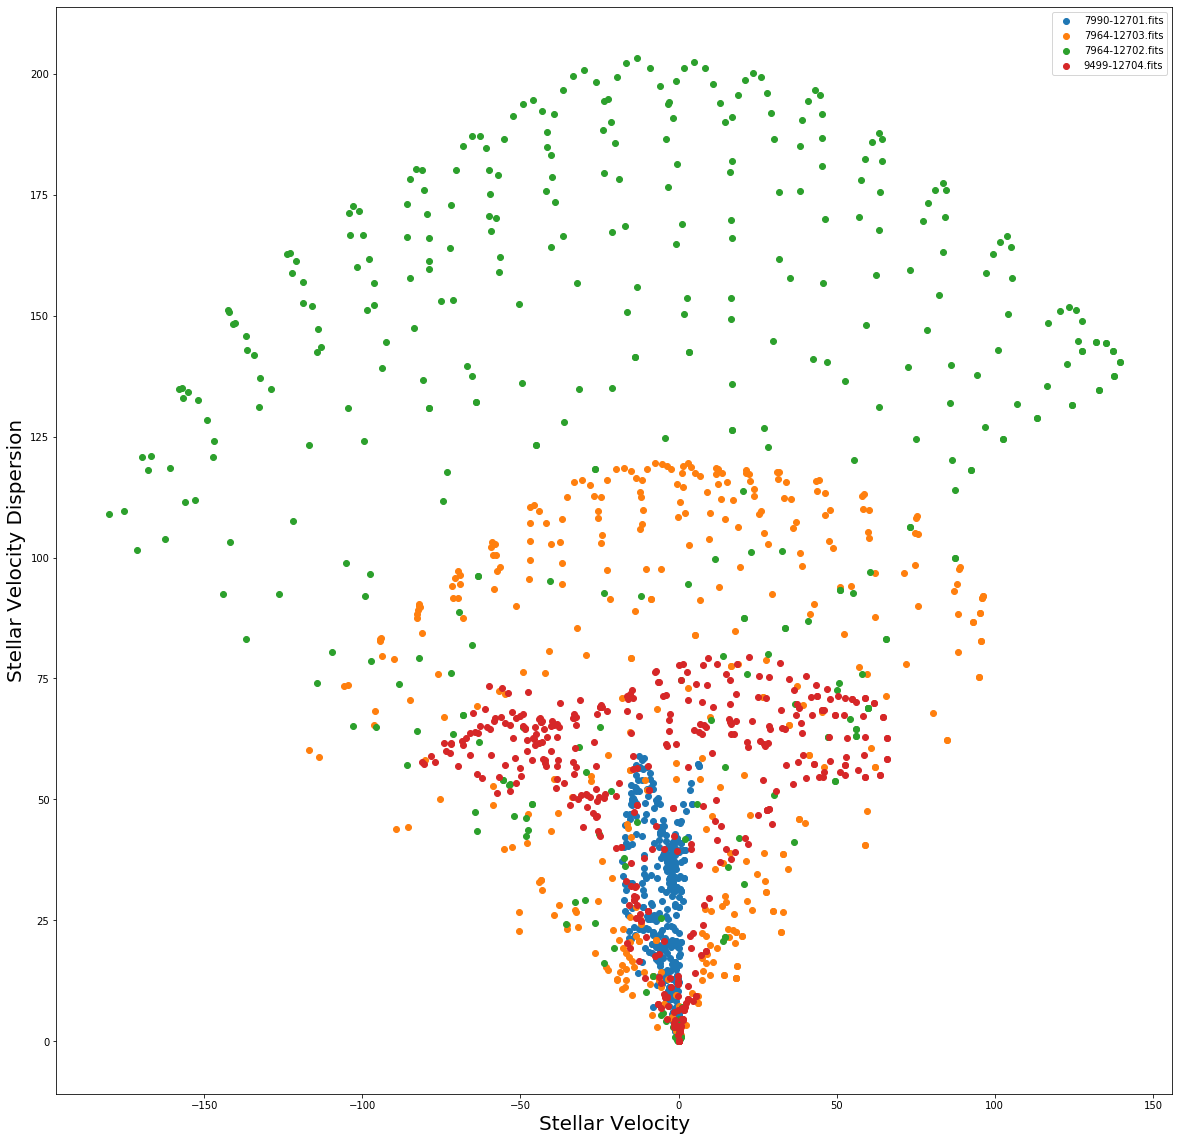

In [29]:
# It is still interesting to look at all of the data points individually:
plt.clf()
fig = plt.figure(figsize=(20,20))
for j in range(4):#len(plates)):
    plt.scatter(map_ml_stel_vel[j], map_ml_stel_disp[j], label=str(plates[j]))
plt.legend()
plt.xlabel('Stellar Velocity', size=20)
plt.ylabel('Stellar Velocity Dispersion', size=20)
plt.show()

check 1 False
check 2 True
(19, 800)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
(2, 800)


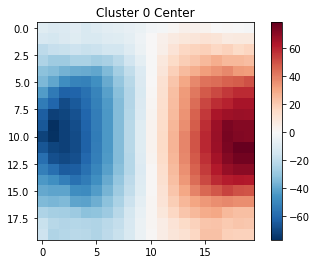

(20, 20)
This is the number of galaxies in this cluster 18


<Figure size 432x288 with 0 Axes>

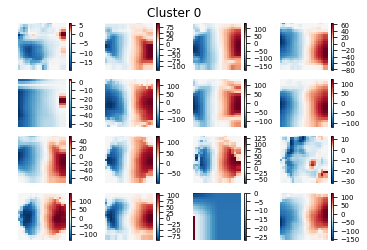

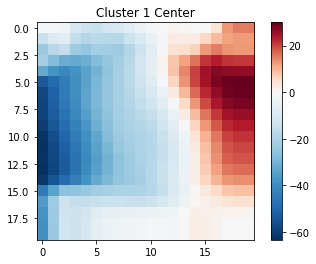

This is the number of galaxies in this cluster 1


<Figure size 432x288 with 0 Axes>

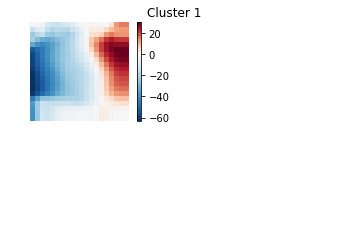

In [50]:
# The initial problem with clustering is that when you go from 2 to 3 clusters, there are galaxies
# that occupy clusters by themselves, so I would like to remove them from the sample
# at least so they're not part of the clustering

#no_zeros = np.ma.masked_where(map_ml_all_stel==0, map_ml_all_stel)
no_inf = np.ma.masked_where(np.isinf(map_ml_all_stel), map_ml_all_stel)
no_nan = np.ma.masked_where(np.isnan(no_inf), no_inf)

data_cluster = no_nan.filled()

shape = int(np.sqrt(length_cube))


'''for j in range(10):
    print(data_cluster)
'''

#np.isfinite(X).all()

print('check 1', np.any(np.isnan(data_cluster))) # you want this to be False
print('check 2', np.all(np.isfinite(data_cluster))) # and this to be true


#np.ma.masked_where(np.isnan(map_ml_all_stel), map_ml_all_stel)
#print(data_cluster[len(plates)-1])


from sklearn.cluster import KMeans
nclusters=2
kmeans = KMeans(n_clusters=nclusters, random_state=0)
print(np.shape(data_cluster))
clusters = kmeans.fit_predict(data_cluster)
print(clusters)
print(np.shape(kmeans.cluster_centers_))
centers = kmeans.cluster_centers_[:,:400].reshape(nclusters, shape, shape)

# These are meant to be repopulated every time you cut the galaxies
bad_galaxies = np.zeros(np.shape(data_ml_2d_vel))
bad_galaxies_ifus = []

counter=0

for i in range(nclusters):
    plt.clf()
    plt.imshow(centers[i], cmap='RdBu_r',norm=MidpointNormalize(midpoint=0))#, vmin=-100, vmax=100)
    plt.colorbar()
    plt.title('Cluster '+str(i)+' Center')
    plt.show()
    
    cluster={}
    cluster_d={}
    ifu={}
    #cluster_name=[]
    for n in range(nclusters):

        cluster[n]=[]
        ifu[n]=[]
        cluster_d[n]=[]
        for j in range(np.shape(data_ml_2d_vel)[0]):
            if clusters[j]==n:
                cluster[n].append(np.reshape(data_ml_2d_vel[j,:],(shape,shape)))
                cluster_d[n].append(np.reshape(data_ml_2d_disp[j,:],(shape,shape)))
                ifu[n].append(existing_plateifus[j])
        #cluster_name.append(str(cluster[n]))
        if len(ifu[n])==1:
            if ifu[n] in bad_galaxies_ifus:
                continue
            bad_galaxies_ifus.append(ifu[n])
            #bad_galaxies_ifus_master.append(ifu[n])
            print(np.shape(cluster[n][0]))
            bad_galaxies[counter,:,:] = cluster[n][0]
            #bad_galaxies_master[counter_master,:,:] = cluster[n][0]
            counter+=1
            #counter_master+=1
    nclusters_list = np.arange(0,nclusters)
    
    plt.clf()
    fig=plt.figure()
    #fig.subplots_adjust(hspace = .5, wspace=.001)
    plt.title('Cluster '+str(i))
    plt.axis('off')
    print('This is the number of galaxies in this cluster '+str(np.shape(cluster[i])[0]))
    if np.shape(cluster[i])[0] < 16:
            if np.shape(cluster[i])[0] < 9:
                if np.shape(cluster[i])[0] < 4:
                    for j in range(np.shape(cluster[i])[0]):
                        ax = fig.add_subplot(2,2,j+1)
                        im = ax.imshow(cluster[i][j], cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))#, vmin=-100, vmax=100)
                        plt.colorbar(im)
                        ax.axis('off')
                    plt.show()

                else:
                    for j in range(np.shape(cluster[i])[0]):
                        ax = fig.add_subplot(3,3,j+1)
                        im = ax.imshow(cluster[i][j], cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))#, vmin=-100, vmax=100)
                        plt.colorbar(im)
                        ax.axis('off')
                    plt.show()
            else:
                for j in range(np.shape(cluster[i])[0]):
                    ax = fig.add_subplot(4,4,j+1)
                    im = ax.imshow(cluster[i][j], cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))#, vmin=-100, vmax=100)
                    plt.colorbar(im)
                    ax.axis('off')
                plt.show()
    else:
        for j in range(16):
            ax = fig.add_subplot(4,4,j+1)
            im = ax.imshow(cluster[i][j], cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))#, vmin=-100, vmax=100)
            cbar = plt.colorbar(im)
            cbar.ax.tick_params(labelsize=7) 
            ax.axis('off')
        plt.show()
        
    # Okay so if there's only one object in a cluster delete that object and add it to 'bad list'
    
 

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  REFF    = '3.19503 '                                                            PA      = '6.101694915254237'                                                   EXT0    = 'De-rotated Independent Spaxels, Stellar Velocity'                    EXT1    = 'De-rotated Independent Spaxels, Stellar Velocity Dispersion'         EXT2    = 'De-rotated Independent Spaxels, Gas Velocity'                        EXT3    = 'De-rotated Independent Spaxels, Gas Velocity Dispersion'             EXT4    = 'De-rotated Independent Spaxels, Stellar Velocity Error'              EXT5    = 'De-rotated Independent Spaxels, Stellar Velocity Dispersion Error'   EXT6    = 'De-rotated Independent Spaxel

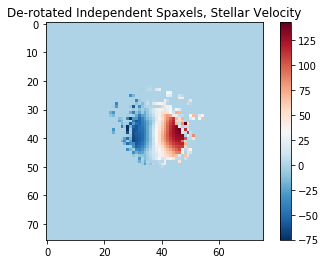

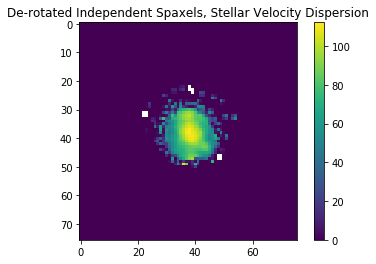

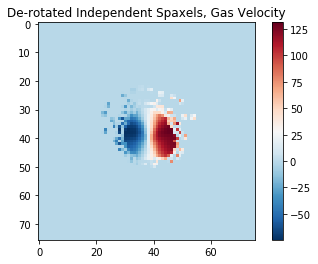

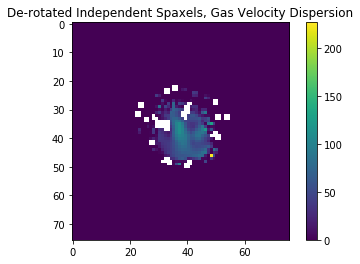

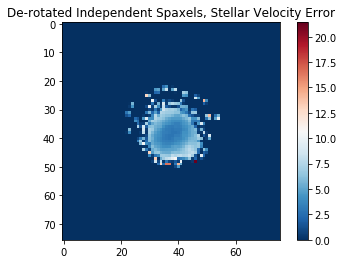

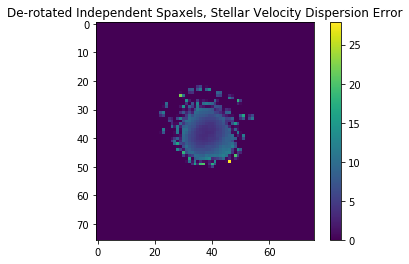

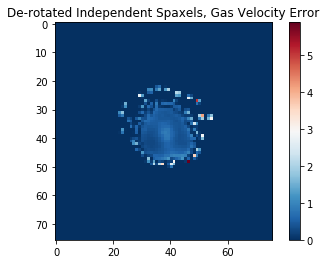

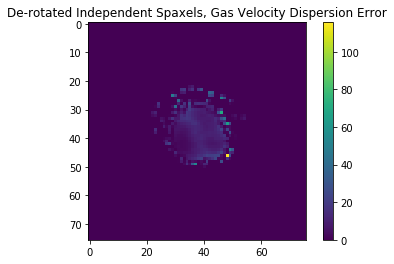

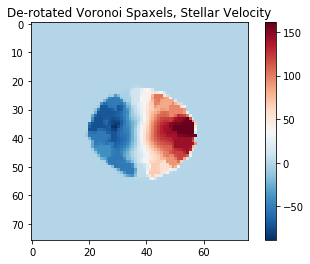

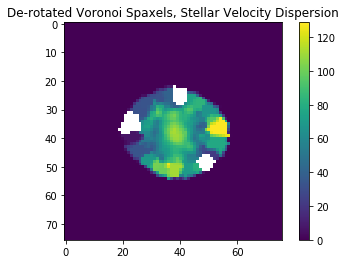

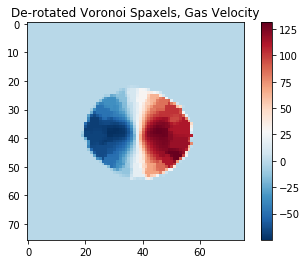

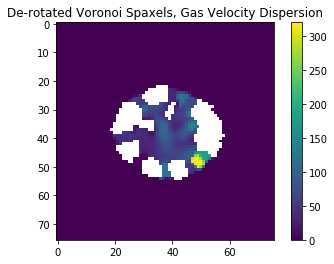

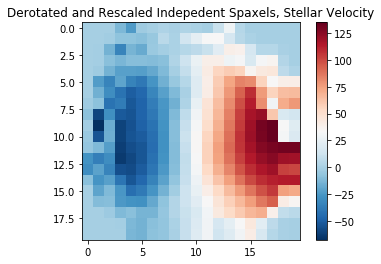

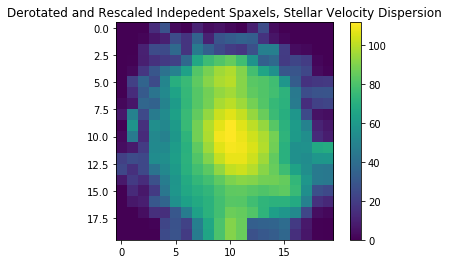

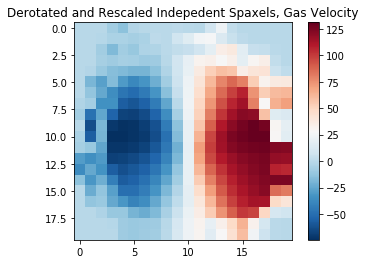

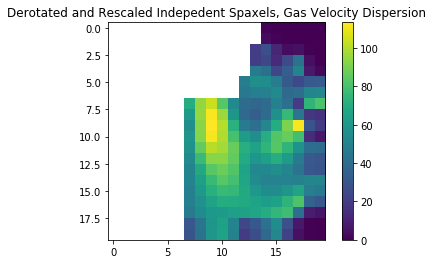

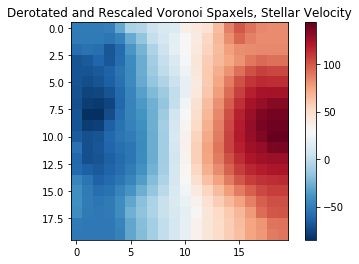

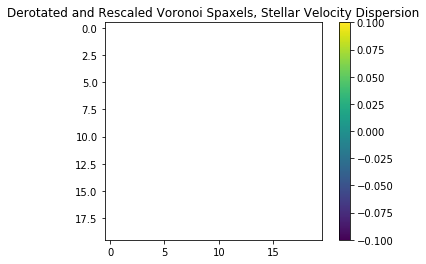

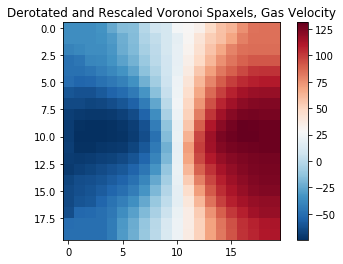

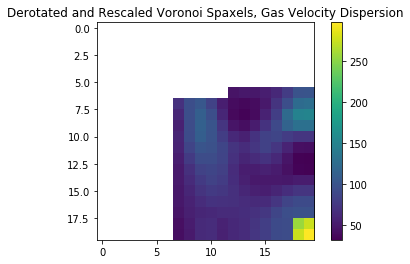

In [21]:
print(full_cube[0].header)

for j in range(20):
    j=j+1
    extension = 'EXT'+str(j-1)
    if (j % 2) == 0:
        
        #this means it is even
        plt.clf()
        plt.imshow(full_cube[j].data, cmap='viridis')
        plt.title(str(full_cube[0].header[extension]))
        plt.colorbar()
        plt.show()
    else:
        plt.clf()
        plt.imshow(full_cube[j].data, cmap='RdBu_r')
        plt.title(str(full_cube[0].header[extension]))
        plt.colorbar()
        plt.show()



In [ ]:
'''rotate_PA.append(PA_kin_by_hand)
    #rotate_PA_e.append(std_avg)
    rotate_ifu.append(ifu_name[o])
    r_eff_rot.append(r_eff[o])'''

'''# data_ml_rot, data_ml_rot_sig, data_ml_rot_gas, data_ml_rot_gas_sig == de-rotated independent spax
# data_ml_rot_vor, data_ml_rot_vor_sig, data_ml_rot_vor_gas, data_ml_rot_vor_gas_sig == de-rotated vor
# data_ml_rot_e, data_ml_rot_sig_e, data_ml_rot_gas_e, data_ml_rot_gas_sig_e == de-rotated error map
# data_vel, data_sig, data_gas, data_gas_sig == rescaled and derotated independent
# data_vel_vor, data_sig_vor, data_gas_vor, data_gas_sig_vor == rescaled and deorated voronoi'''

print(np.shape(r_eff_rot), np.shape(rotate_ifu))
print(rotate_ifu)



for j in range(len(r_eff_rot)):
    hdul = pyfits.HDUList()
    hdul.append(pyfits.PrimaryHDU())
    hdr = hdul[0].header
    hdr['REFF'] = str(r_eff_rot[j])
    hdr['PA'] = str(rotate_PA[j])
    
    hdr['EXT0'] = 'De-rotated Independent Spaxels, Stellar Velocity'
    hdr['EXT1'] = 'De-rotated Independent Spaxels, Stellar Velocity Dispersion'
    hdr['EXT2'] = 'De-rotated Independent Spaxels, Gas Velocity'
    hdr['EXT3'] = 'De-rotated Independent Spaxels, Gas Velocity Dispersion'
    
    hdul.append(pyfits.ImageHDU(data=data_ml_rot[j]))
    hdul.append(pyfits.ImageHDU(data=data_ml_rot_sig[j]))
    hdul.append(pyfits.ImageHDU(data=data_ml_rot_gas[j]))
    hdul.append(pyfits.ImageHDU(data=data_ml_rot_gas_sig[j]))
    
    hdr['EXT4'] = 'De-rotated Independent Spaxels, Stellar Velocity Error'
    hdr['EXT5'] = 'De-rotated Independent Spaxels, Stellar Velocity Dispersion Error'
    hdr['EXT6'] = 'De-rotated Independent Spaxels, Gas Velocity Error'
    hdr['EXT7'] = 'De-rotated Independent Spaxels, Gas Velocity Dispersion Error'
    
    hdul.append(pyfits.ImageHDU(data=data_ml_rot_e[j]))
    hdul.append(pyfits.ImageHDU(data=data_ml_rot_sig_e[j]))
    hdul.append(pyfits.ImageHDU(data=data_ml_rot_gas_e[j]))
    hdul.append(pyfits.ImageHDU(data=data_ml_rot_gas_sig_e[j]))
    
    hdr['EXT8'] = 'De-rotated Voronoi Spaxels, Stellar Velocity'
    hdr['EXT9'] = 'De-rotated Voronoi Spaxels, Stellar Velocity Dispersion'
    hdr['EXT10'] = 'De-rotated Voronoi Spaxels, Gas Velocity'
    hdr['EXT11'] = 'De-rotated Voronoi Spaxels, Gas Velocity Dispersion'
    
    hdul.append(pyfits.ImageHDU(data=data_ml_rot_vor[j]))
    hdul.append(pyfits.ImageHDU(data=data_ml_rot_vor_sig[j]))
    hdul.append(pyfits.ImageHDU(data=data_ml_rot_vor_gas[j]))
    hdul.append(pyfits.ImageHDU(data=data_ml_rot_vor_gas_sig[j]))
    
    hdr['EXT12'] = 'Derotated and Rescaled Indepedent Spaxels, Stellar Velocity'
    hdr['EXT13'] = 'Derotated and Rescaled Indepedent Spaxels, Stellar Velocity Dispersion'
    hdr['EXT14'] = 'Derotated and Rescaled Indepedent Spaxels, Gas Velocity'
    hdr['EXT15'] = 'Derotated and Rescaled Indepedent Spaxels, Gas Velocity Dispersion'
    
    hdul.append(pyfits.ImageHDU(data=data_vel[j]))
    hdul.append(pyfits.ImageHDU(data=data_sig[j]))
    hdul.append(pyfits.ImageHDU(data=data_gas[j]))
    hdul.append(pyfits.ImageHDU(data=data_gas_sig[j]))
    
    hdr['EXT16'] = 'Derotated and Rescaled Voronoi Spaxels, Stellar Velocity'
    hdr['EXT17'] = 'Derotated and Rescaled Voronoi Spaxels, Stellar Velocity Dispersion'
    hdr['EXT18'] = 'Derotated and Rescaled Voronoi Spaxels, Gas Velocity'
    hdr['EXT19'] = 'Derotated and Rescaled Voronoi Spaxels, Gas Velocity Dispersion'
    
    hdul.append(pyfits.ImageHDU(data=data_vel_vor[j]))
    hdul.append(pyfits.ImageHDU(data=data_sig_vor[j]))
    hdul.append(pyfits.ImageHDU(data=data_gas_vor[j]))
    hdul.append(pyfits.ImageHDU(data=data_gas_sig_vor[j]))
    
    
    
    hdul.writeto('kin_maps_derotated_and_rescaled/'+str(rotate_ifu[j])+'.fits', clobber='True')
    
   